In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive/My Drive/ToxicCommentDetection/main

/content/drive/My Drive/ToxicCommentDetection/main


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['uncased-l12-h768-a12', 'jigsaw-toxic-comment-classification-challenge']


In [0]:
from fastai.text import *

In [0]:
train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
train['comment_text'] = train['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [0]:
test = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")

test_id = test['id']
test['comment_text'] = test['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [0]:
data = (TextList.from_df(train, cols='comment_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,". xxmaj he seems to care more about the formatting than the actual info . xxbos "" \n xxmaj more \n i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of "" "" types of accidents "" "" xxup -i think the references may need tidying so that they are all in the"
1,"which future issues will be delivered to you , or unsubscribe from this notification by following the link . xxmaj thank you . \n \n xxmaj this is an automated delivery by \n \n xxmaj article moves \n xxmaj could you explain your move on xxmaj xxunk mm xxup xxunk field xxunk ? xxmaj in general it is good practice to propose a move on talk first"
2,"are not contradictions . xxmaj they are an essential feature of the study , specified and discussed in the paper . xxmaj there is no contradiction here . xxmaj out it goes . ( ) \n \n xxmaj contrary evidence and xxup xxunk tests \n \n xxmaj oohashi et al . pictured human brains when the test persons were either exposed or not exposed to ultrasonic stimulus ."
3,"( it is located at the very top of any xxmaj wikipedia page when you are logged in ) , and then selecting "" "" xxmaj image "" "" from the dropdown box . xxmaj note that any non - free media lacking such an explanation will be deleted one week after they have been uploaded , as described on criteria for speedy deletion . xxmaj if you have any"
4,"claims to have originated the idea of recently observed xxunk in 1969 in the paper "" "" xxmaj destruction of xxmaj xxunk in xxmaj xxunk 4he xxmaj films and the xxmaj prediction of a xxmaj new xxmaj crystalline xxmaj phase of 4he with xxmaj bose - xxmaj einstein xxmaj condensation "" "" in xxmaj physics xxmaj letters , xxmaj vol xxup xxunk , number 5 , 3 , , xxmaj"


In [0]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


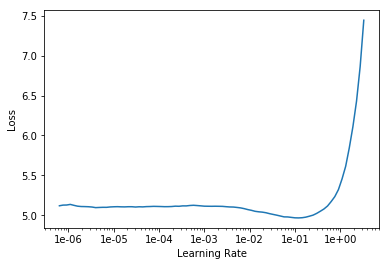

In [0]:
learn.recorder.plot()


In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.091016,3.872453,0.322813,39:21


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
label_cols = ['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']

In [0]:
label_cols = ['Science and Engineering',
 'Music and Audio',
 'Hardware',
 'Platforms',
 'Consumer Electronics',
 'Content and Publishing',
 'Data and Analytics',
 'Financial Services',
 'Hardware',
 'Internet Services',
 'Lending and Investments',
 'Media and Entertainment',
 'Mobile',
 'Music and Audio',
 'Platforms',
 'Sales and Marketing',
 'Science and Engineering',
 'Software',
 'Video']

In [0]:
test_datalist = TextList.from_df(test, cols='comment_text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='comment_text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos i xxup am xxup an xxup loser xxrep 4 = i xxup am xxup an xxup loser = = = = i xxup am xxup an xxup loser xxrep 4 = i xxup am xxup an xxup loser = = = = i xxup am xxup an xxup loser xxrep 4 = i xxup am xxup an xxup loser = = = = i xxup am xxup an xxup,toxic
"xxbos xxmaj so i was all like who farted , than i realized i need to be banned . xxmaj so i was all like who farted , than i realized i need to be banned . xxmaj so i was all like who farted , than i realized i need to be banned . xxmaj so i was all like who farted , than i realized i need to",toxic
xxbos xxup suck xxup my xxup lick xxup you xxup can xxup suck xxup my xxup lick xxup you xxup can xxup suck xxup my xxup lick xxup you xxup can xxup suck xxup my xxup lick xxup you xxup can xxup suck xxup my xxup lick xxup you xxup can xxup suck xxup my xxup lick xxup you xxup can xxup suck xxup my xxup lick xxup you xxup,toxic
"xxbos a xxmaj short xxmaj history of xxmaj republican xxmaj sinn xxmaj féin \n \n xxmaj in 1902 , xxmaj arthur xxmaj griffith , xxmaj editor of the xxmaj united xxmaj irishman , presented to the third annual convention of xxmaj xxunk na xxunk the most revolutionary political idea since the fall of xxmaj parnell ; it was that the elected xxmaj irish xxmaj members of xxmaj parliament should",
"xxbos "" xxunk = keep ( and possibly merge ) } } \n \n xxmaj page xxmaj creation \n xxmaj so , i started the page . xxmaj this is probably going to get heated , some people accusing me of saying the xxmaj course is a "" "" hoax "" "" and all that . xxmaj but i think this is an issue worthy of a page",


In [0]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

In [0]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


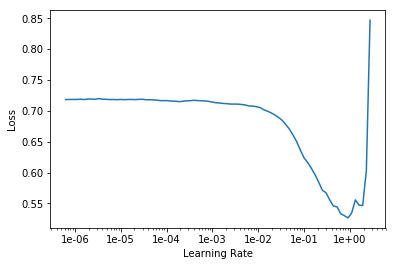

In [0]:
learn_classifier.recorder.plot()


In [0]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.092378,0.071467,17:46


In [0]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.058282,0.110831,21:18


In [0]:
learn_classifier.freeze_to(-3)
learn_classifier.x(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.050159,0.171168,28:09


In [0]:
learn_classifier.show_results()


text,target,prediction
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene,toxic;severe_toxic;obscene;insult
xxbos xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup all ! ! xxup fuck xxup you xxup,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
xxbos xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
"xxbos xxup dust xxup filter , xxup if xxup you xxup rvv xxup it xxup again ! i xxup will xxup fuckin xxup kill xxup you ! i xxup will xxup block xxup you , i xxup will xxup blank xxup your xxup talk xxup page , i xxup will xxup steal xxup your xxup password , i xxup will xxup take xxup over xxup you ! i xxup will",toxic;severe_toxic;obscene;threat;insult,toxic
xxbos xxup in xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup name xxup of xxup xxunk xxup the xxup,,


In [0]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()


In [0]:
labels

array([[9.883897e-01, 2.623884e-01, 9.571094e-01, 3.149130e-01, 8.940867e-01, 1.850217e-01],
       [3.467371e-03, 1.417886e-04, 1.162976e-03, 9.286470e-05, 6.408545e-04, 2.221961e-04],
       [3.883871e-02, 2.430319e-03, 2.090406e-02, 7.950535e-04, 8.026772e-03, 2.779136e-03],
       [3.973726e-04, 5.405182e-06, 1.415407e-04, 3.100197e-05, 6.837760e-05, 1.746514e-05],
       ...,
       [7.170928e-02, 2.071401e-03, 1.676683e-02, 1.095338e-03, 1.220249e-02, 3.308463e-03],
       [9.681711e-04, 2.607051e-05, 1.463362e-04, 2.938509e-05, 1.122276e-04, 1.300497e-04],
       [8.367985e-03, 1.441929e-04, 9.057145e-04, 1.736582e-04, 9.263147e-04, 1.776602e-03],
       [7.008537e-01, 9.681507e-03, 3.033271e-01, 1.412554e-03, 1.950892e-01, 3.190502e-03]], dtype=float32)

In [0]:
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission.csv', index=False)
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.988390,0.262388,0.957109,0.314913,0.894087,0.185022
1,0000247867823ef7,0.003467,0.000142,0.001163,0.000093,0.000641,0.000222
2,00013b17ad220c46,0.038839,0.002430,0.020904,0.000795,0.008027,0.002779
3,00017563c3f7919a,0.000397,0.000005,0.000142,0.000031,0.000068,0.000017
4,00017695ad8997eb,0.016469,0.000717,0.005396,0.000791,0.003223,0.000434
